## Imports

In [1]:
try:
    from astra.torch.models import ResNetClassifier
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA

In [36]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm

import umap

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier

# Netron, ONNX for model visualization
import netron
import onnx


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset

In [38]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

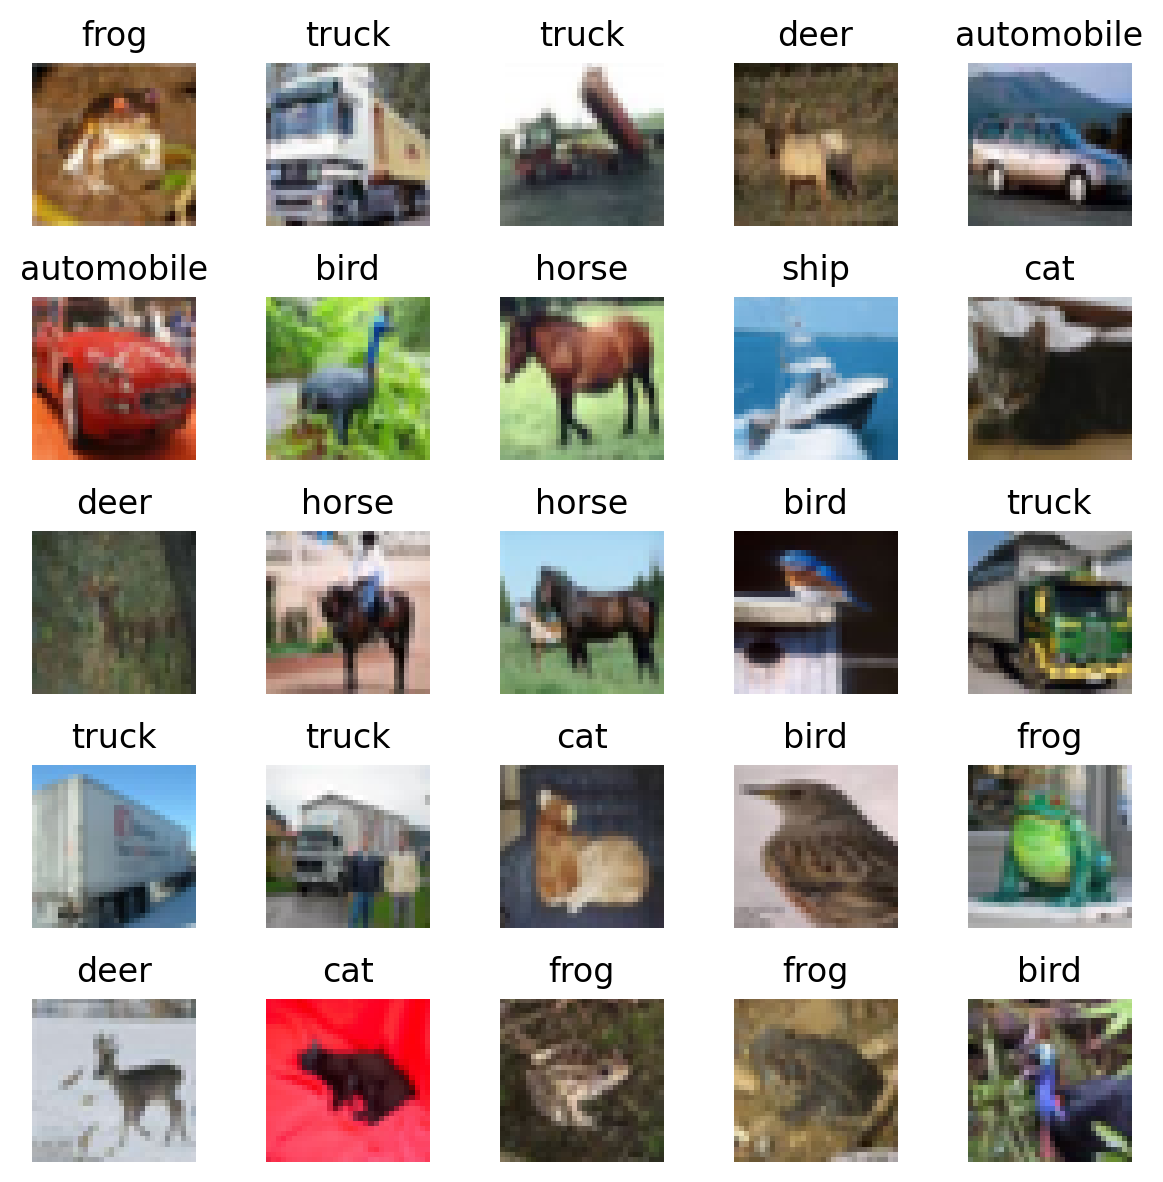

In [39]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()


### Data splitting

In [40]:
n_train = 1000
n_test = 20000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [41]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(f"Length of train set: {len(train_idx)}")
print(f"Length of pool set: {len(pool_idx)}")
print(f"Length of test set: {len(test_idx)}")

Length of train set: 1000
Length of pool set: 39000
Length of test set: 20000


In [42]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

In [43]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [44]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()

train set accuracy: 7.70%


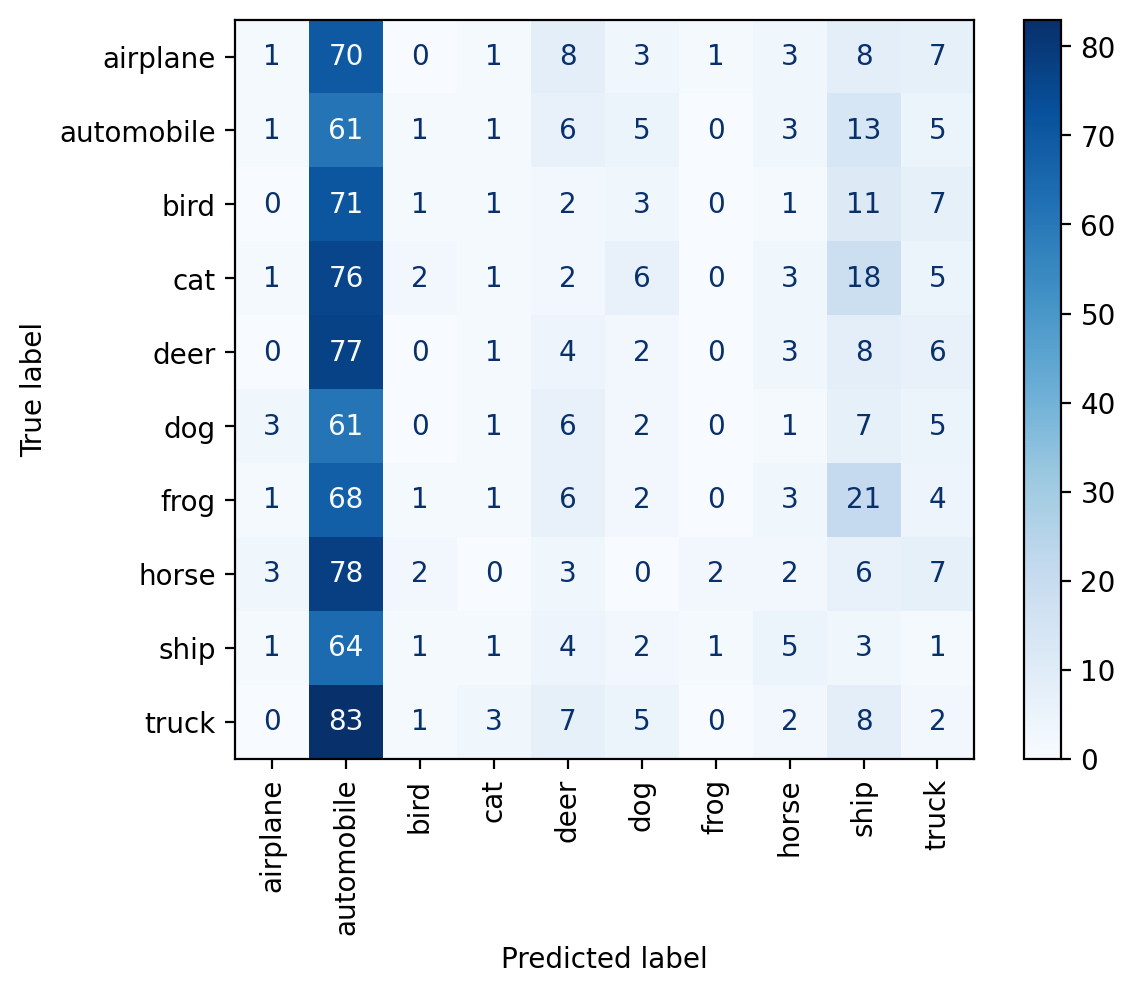

pool set accuracy: 8.37%


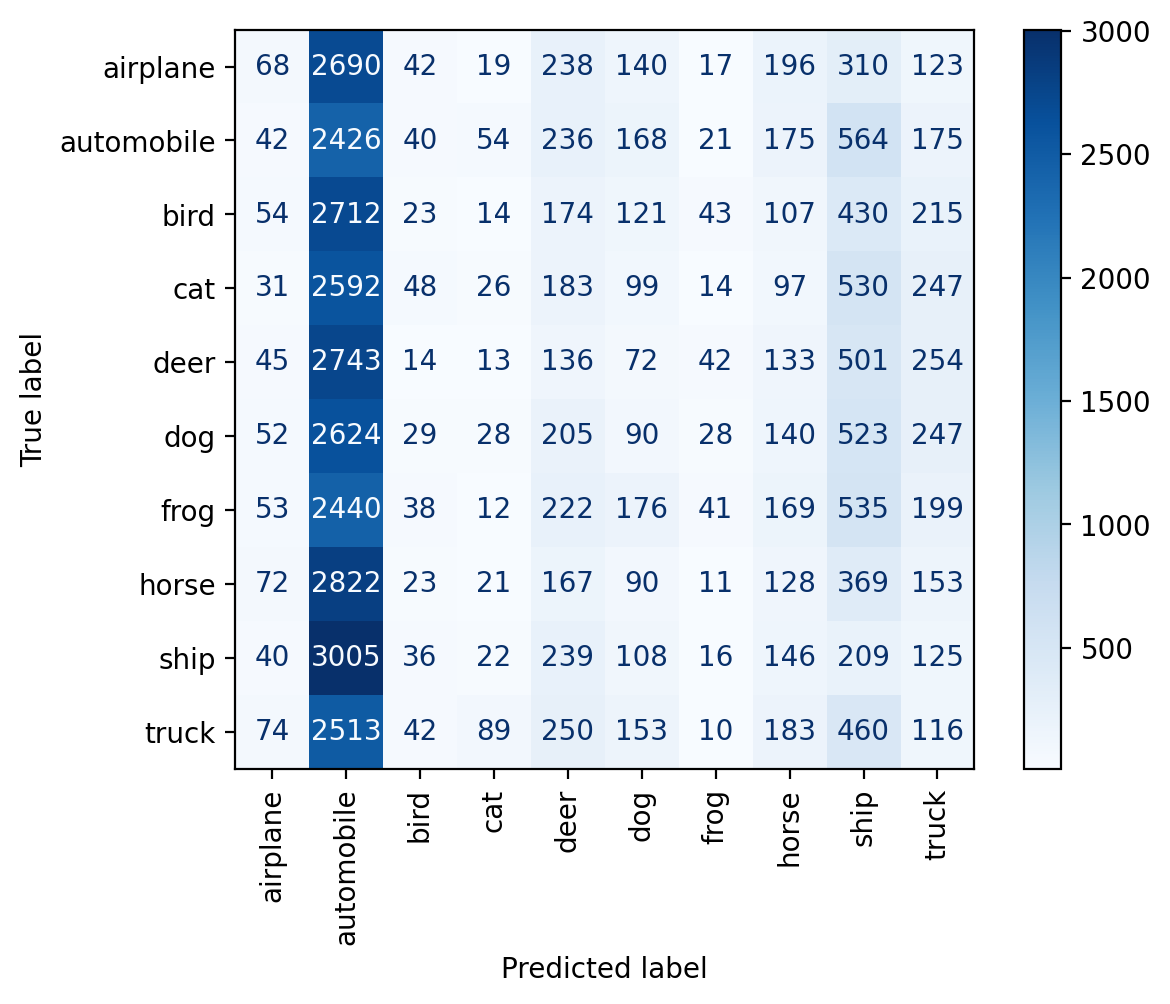

test set accuracy: 8.58%


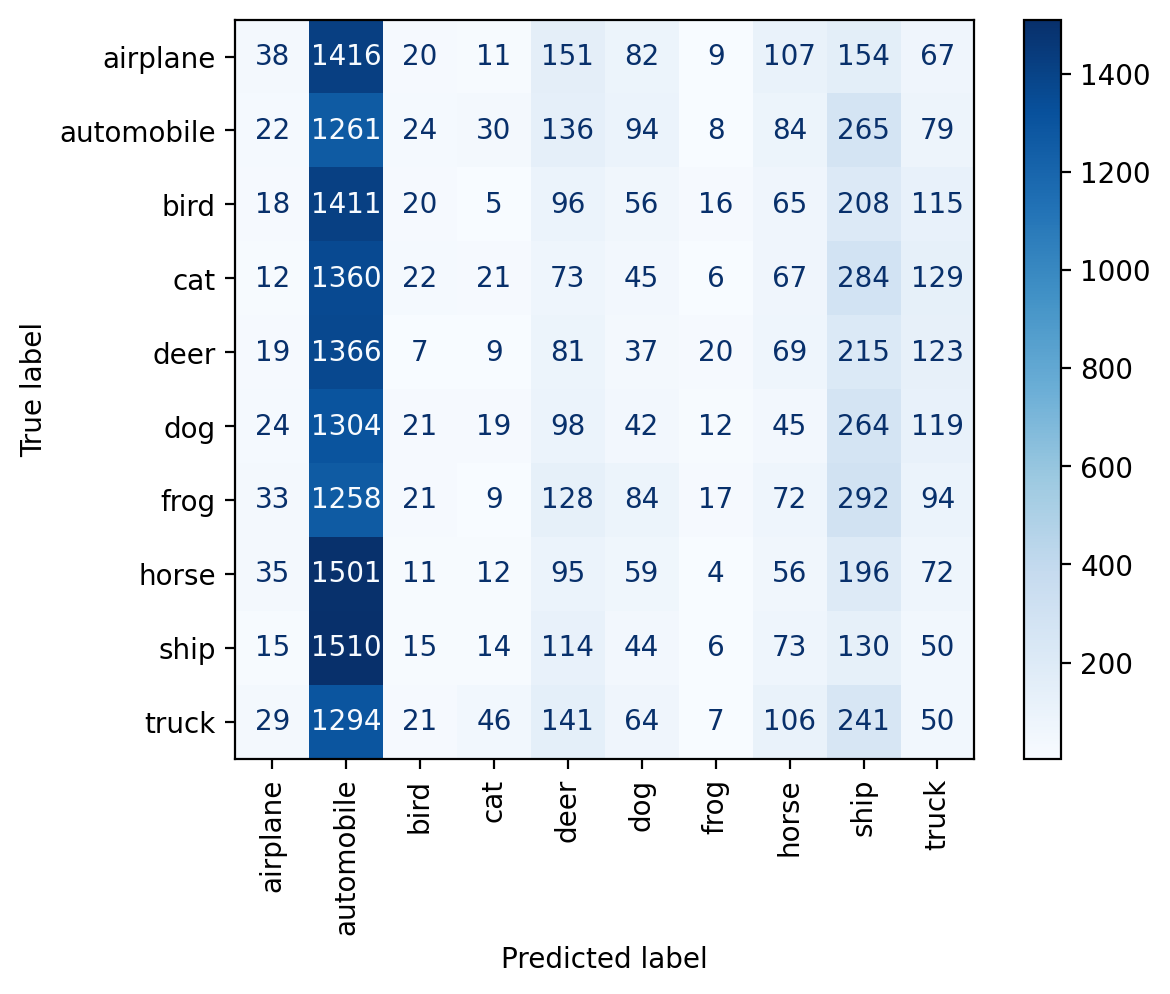

In [45]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

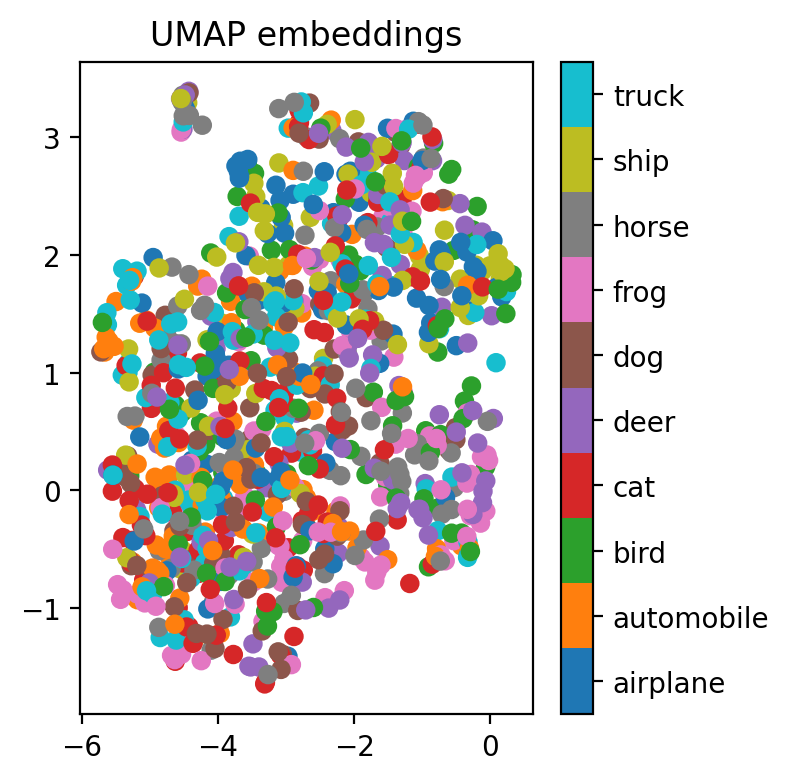

In [46]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

viz_embeddings(resnet, X[train_idx], y[train_idx], device)

#### Train the model on train set

In [171]:
model_only_train = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(model_only_train, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

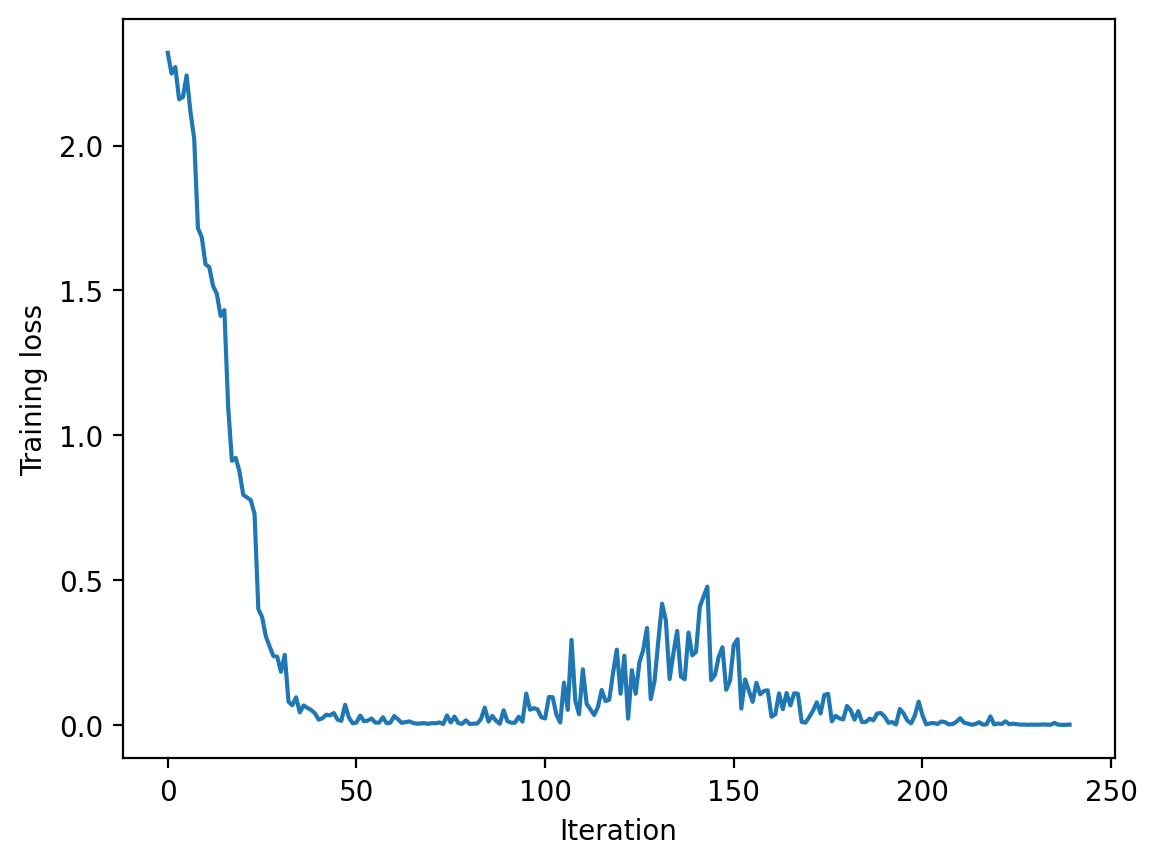

In [97]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


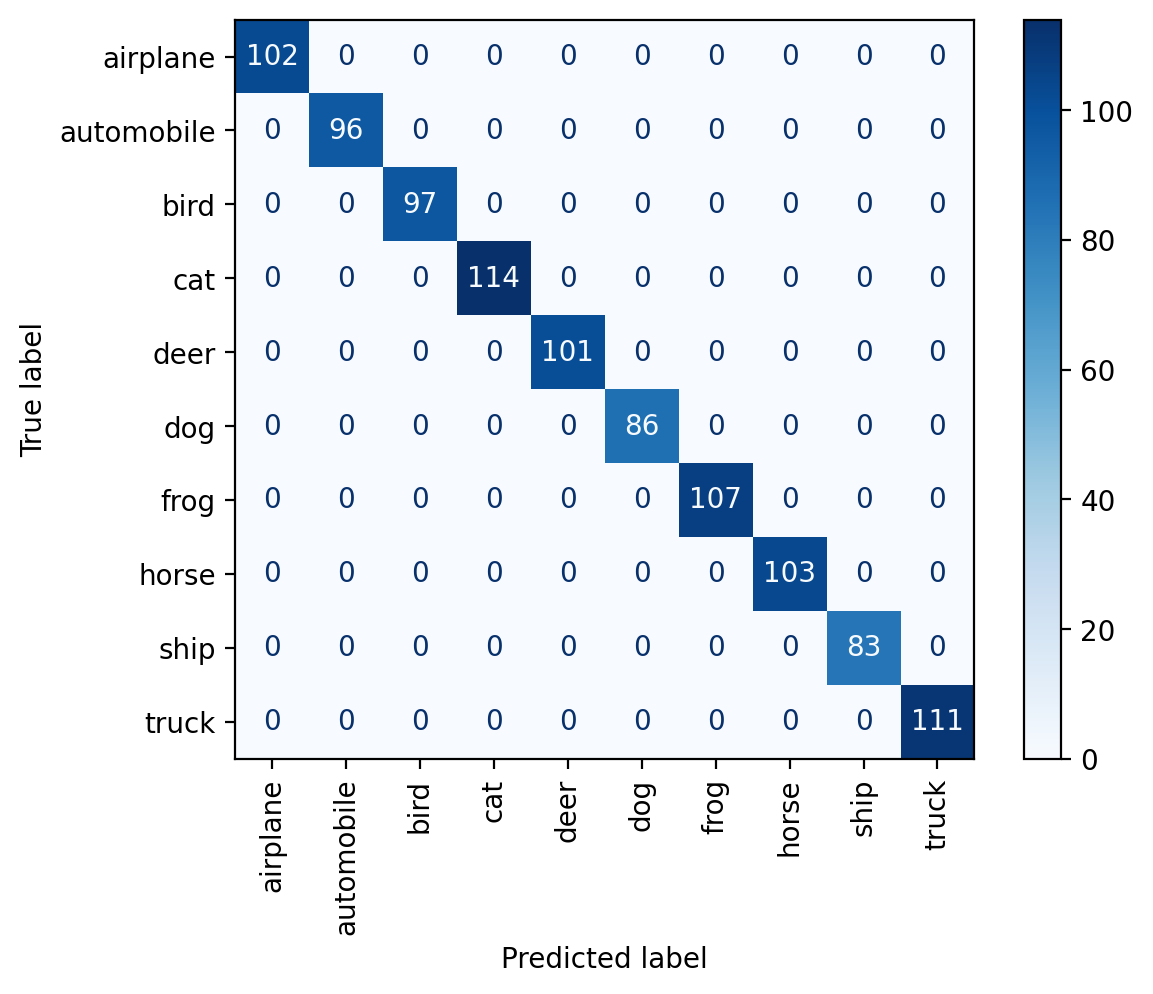

pool set accuracy: 35.95%


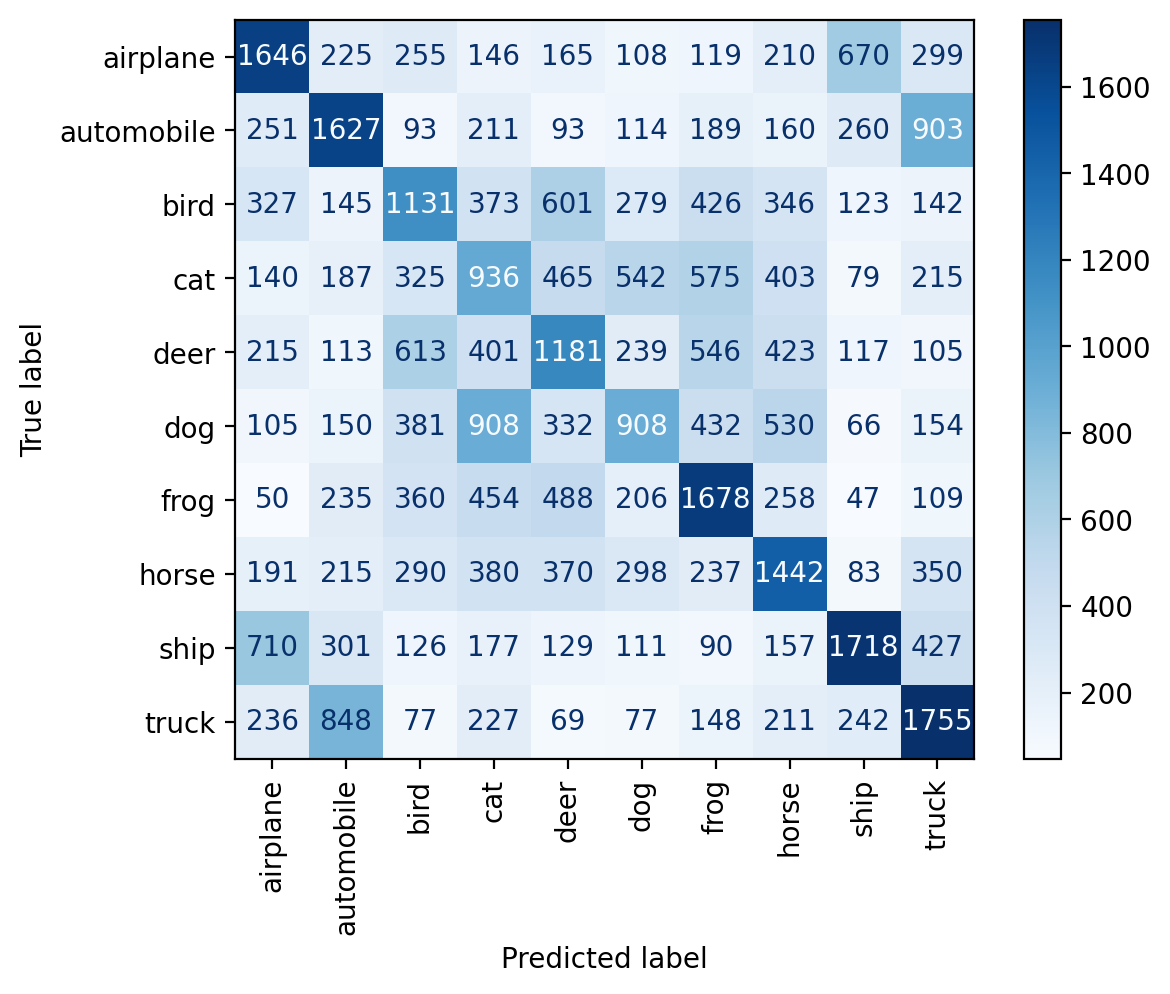

test set accuracy: 35.74%


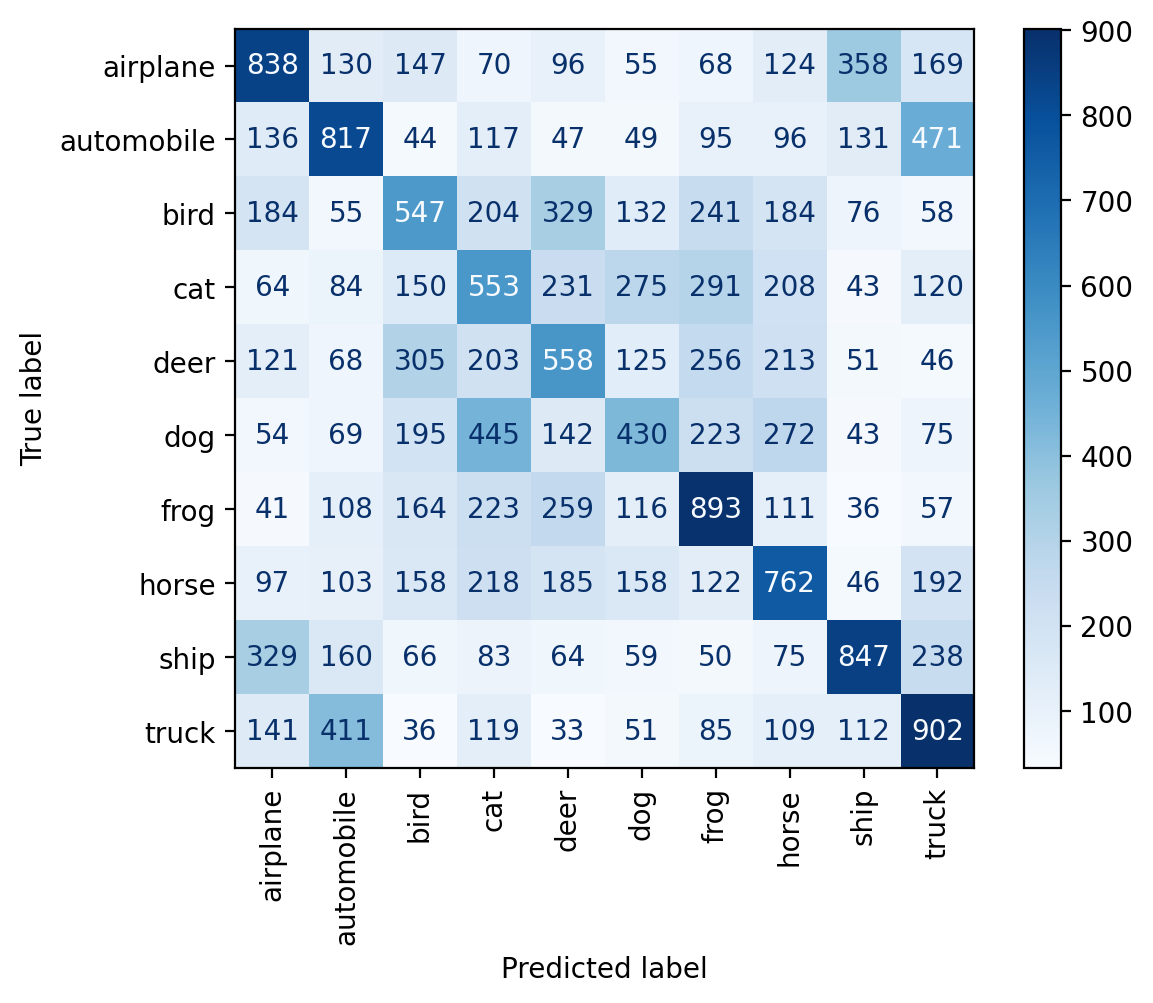

In [172]:
predict(model_only_train, dataset.classes, plot_confusion_matrix=True)

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


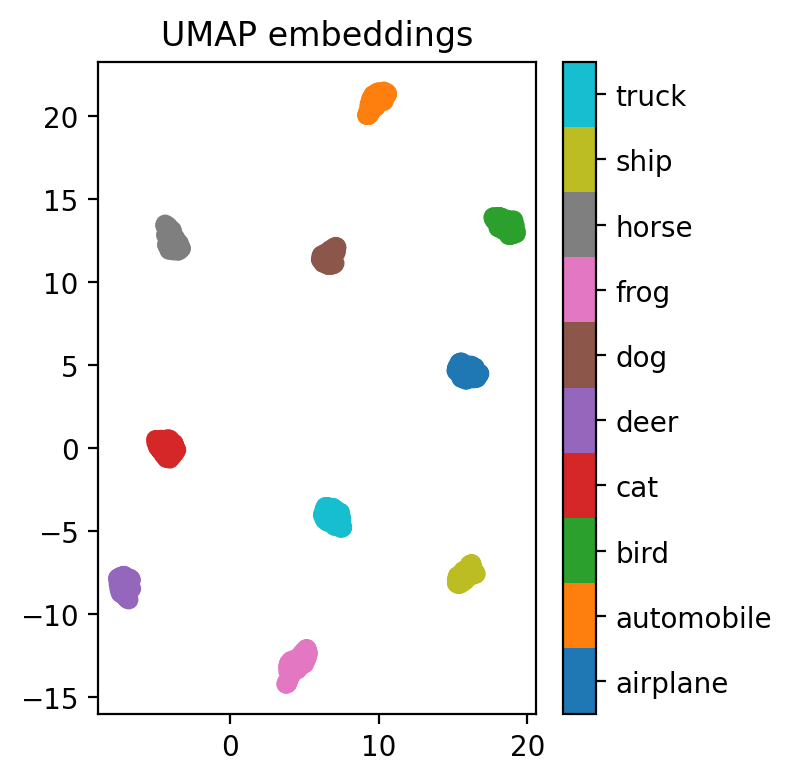

In [99]:
viz_embeddings(model_only_train, X[train_idx], y[train_idx], device)

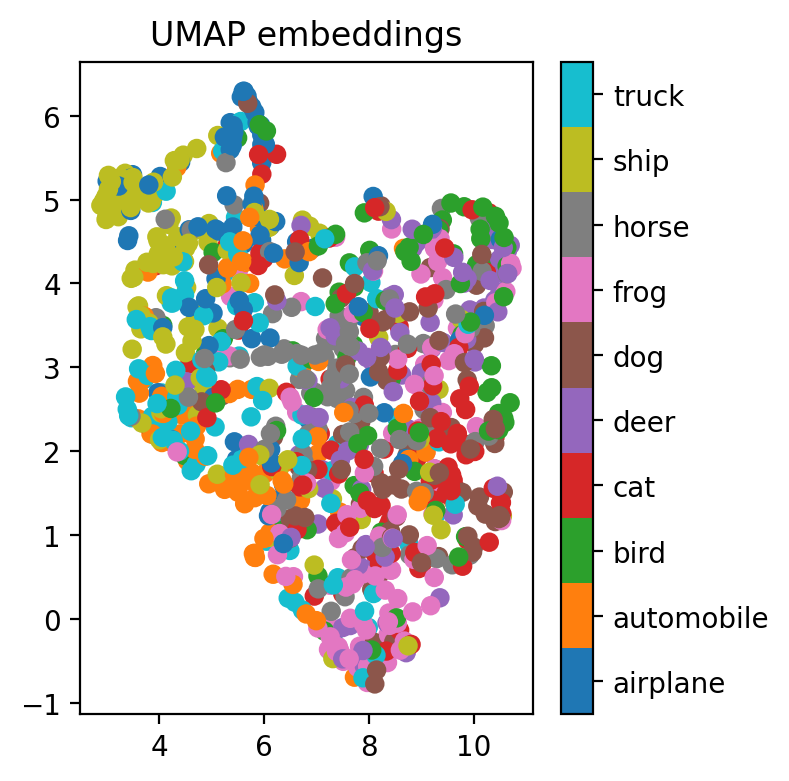

In [100]:
viz_embeddings(model_only_train, X[test_idx[:1000]], y[test_idx[:1000]], device)

### Train on train + pool


In [101]:
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

model_train_plus_pool = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(model_train_plus_pool, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)

Loss: 1.295511: 100%|██████████| 40/40 [00:01<00:00, 35.85it/s]


Epoch 1: 1.6595390411376953


Loss: 1.192479: 100%|██████████| 40/40 [00:01<00:00, 35.90it/s]


Epoch 2: 1.2355460510253906


Loss: 0.914721: 100%|██████████| 40/40 [00:01<00:00, 35.12it/s]


Epoch 3: 1.0314805297851561


Loss: 0.788460: 100%|██████████| 40/40 [00:01<00:00, 35.93it/s]


Epoch 4: 0.8418165679931641


Loss: 0.921840: 100%|██████████| 40/40 [00:01<00:00, 35.85it/s]


Epoch 5: 0.6514999572753907


Loss: 0.431034: 100%|██████████| 40/40 [00:01<00:00, 36.00it/s]


Epoch 6: 0.5277249389648437


Loss: 0.501027: 100%|██████████| 40/40 [00:01<00:00, 35.97it/s]


Epoch 7: 0.3935557357788086


Loss: 0.294622: 100%|██████████| 40/40 [00:01<00:00, 36.16it/s]


Epoch 8: 0.3460622085571289


Loss: 0.503758: 100%|██████████| 40/40 [00:01<00:00, 36.62it/s]


Epoch 9: 0.22095457725524903


Loss: 0.330708: 100%|██████████| 40/40 [00:01<00:00, 36.67it/s]


Epoch 10: 0.29564213066101075


Loss: 0.246103: 100%|██████████| 40/40 [00:01<00:00, 36.10it/s]


Epoch 11: 0.1900052801132202


Loss: 0.109153: 100%|██████████| 40/40 [00:01<00:00, 36.75it/s]


Epoch 12: 0.17611066970825195


Loss: 0.163119: 100%|██████████| 40/40 [00:01<00:00, 35.66it/s]


Epoch 13: 0.09104470224380493


Loss: 0.169838: 100%|██████████| 40/40 [00:01<00:00, 36.09it/s]


Epoch 14: 0.10707370157241822


Loss: 0.125991: 100%|██████████| 40/40 [00:01<00:00, 35.74it/s]


Epoch 15: 0.14090245056152345


Loss: 0.064842: 100%|██████████| 40/40 [00:01<00:00, 36.80it/s]


Epoch 16: 0.1040388243675232


Loss: 0.041773: 100%|██████████| 40/40 [00:01<00:00, 36.42it/s]


Epoch 17: 0.053249561834335324


Loss: 0.009821: 100%|██████████| 40/40 [00:01<00:00, 36.25it/s]


Epoch 18: 0.043817346692085264


Loss: 0.156952: 100%|██████████| 40/40 [00:01<00:00, 36.02it/s]


Epoch 19: 0.021464841830730438


Loss: 0.048270: 100%|██████████| 40/40 [00:01<00:00, 35.01it/s]


Epoch 20: 0.08156358222961425


Loss: 0.138044: 100%|██████████| 40/40 [00:01<00:00, 36.30it/s]


Epoch 21: 0.06124592881202698


Loss: 0.095608: 100%|██████████| 40/40 [00:01<00:00, 36.60it/s]


Epoch 22: 0.12875774393081665


Loss: 0.153269: 100%|██████████| 40/40 [00:01<00:00, 35.99it/s]


Epoch 23: 0.10871703634262085


Loss: 0.077450: 100%|██████████| 40/40 [00:01<00:00, 35.47it/s]


Epoch 24: 0.06120568513870239


Loss: 0.059260: 100%|██████████| 40/40 [00:01<00:00, 35.46it/s]


Epoch 25: 0.05621655244827271


Loss: 0.012899: 100%|██████████| 40/40 [00:01<00:00, 35.45it/s]


Epoch 26: 0.03219776062965393


Loss: 0.004988: 100%|██████████| 40/40 [00:01<00:00, 36.00it/s]


Epoch 27: 0.012630578982830048


Loss: 0.009330: 100%|██████████| 40/40 [00:01<00:00, 36.28it/s]


Epoch 28: 0.004046996954083443


Loss: 0.006199: 100%|██████████| 40/40 [00:01<00:00, 34.92it/s]


Epoch 29: 0.005468952369689941


Loss: 0.011570: 100%|██████████| 40/40 [00:01<00:00, 36.54it/s]


Epoch 30: 0.002575707522034645


Text(0, 0.5, 'Training loss')

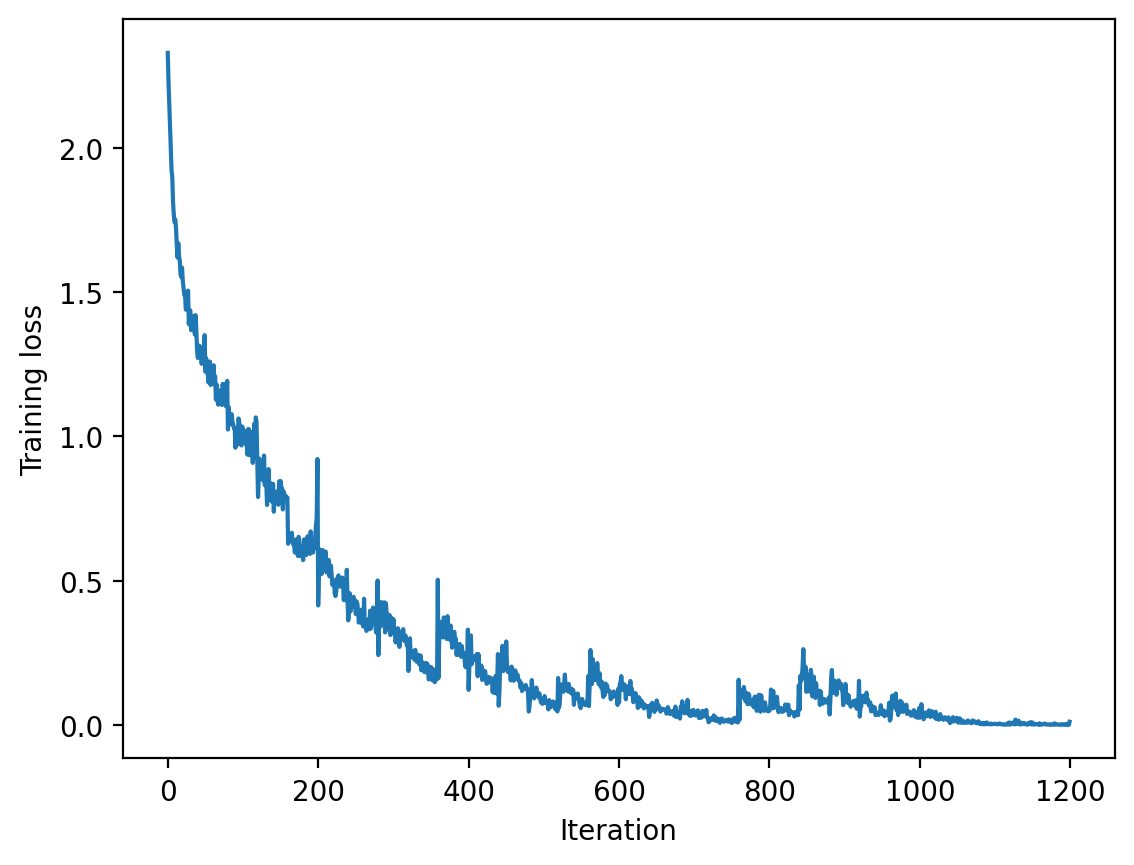

In [102]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss")

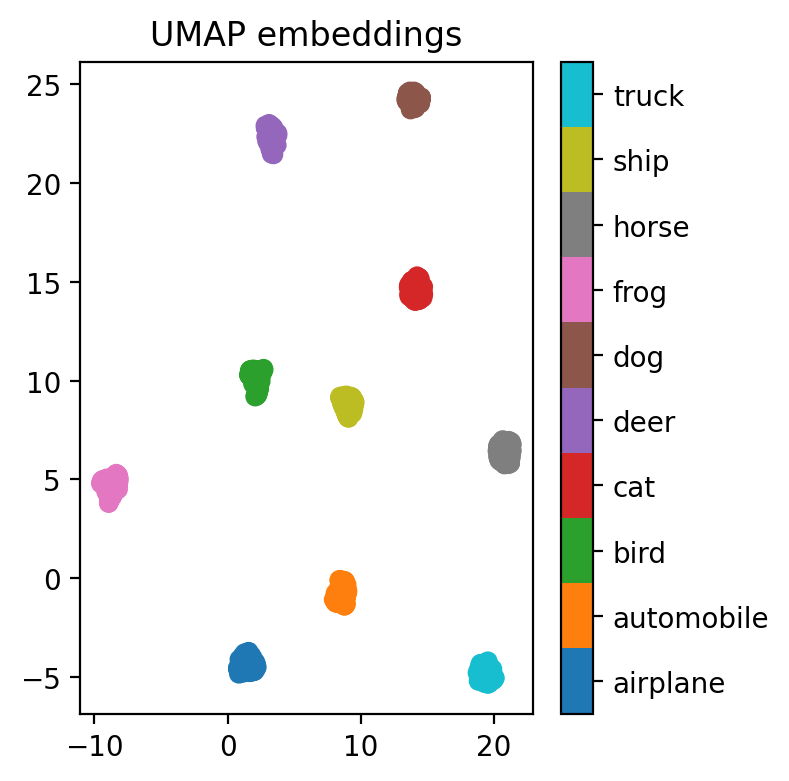

In [103]:
viz_embeddings(model_train_plus_pool, X[train_idx], y[train_idx], device)

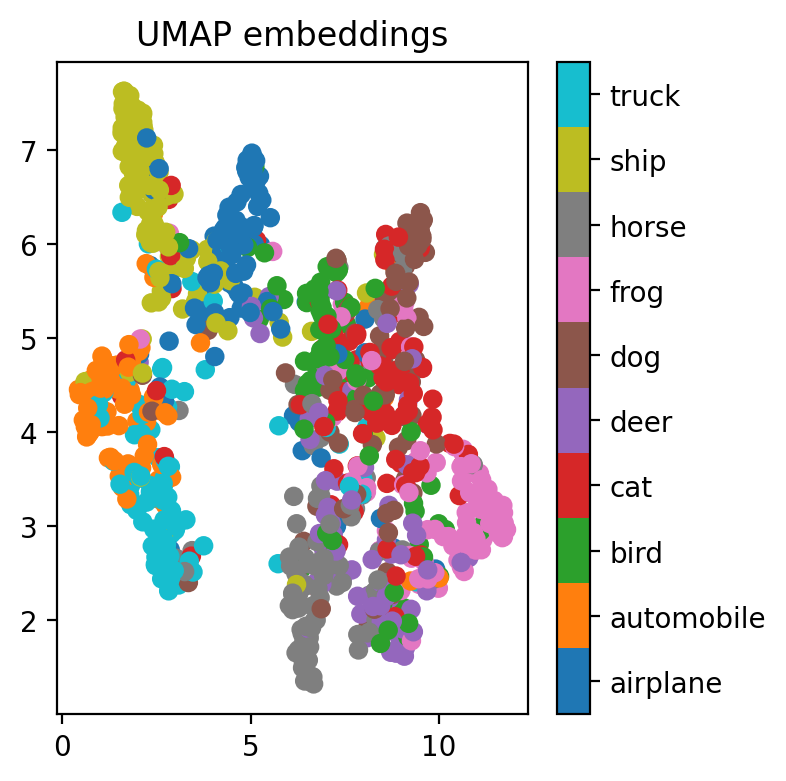

In [104]:
viz_embeddings(model_train_plus_pool, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 100.00%


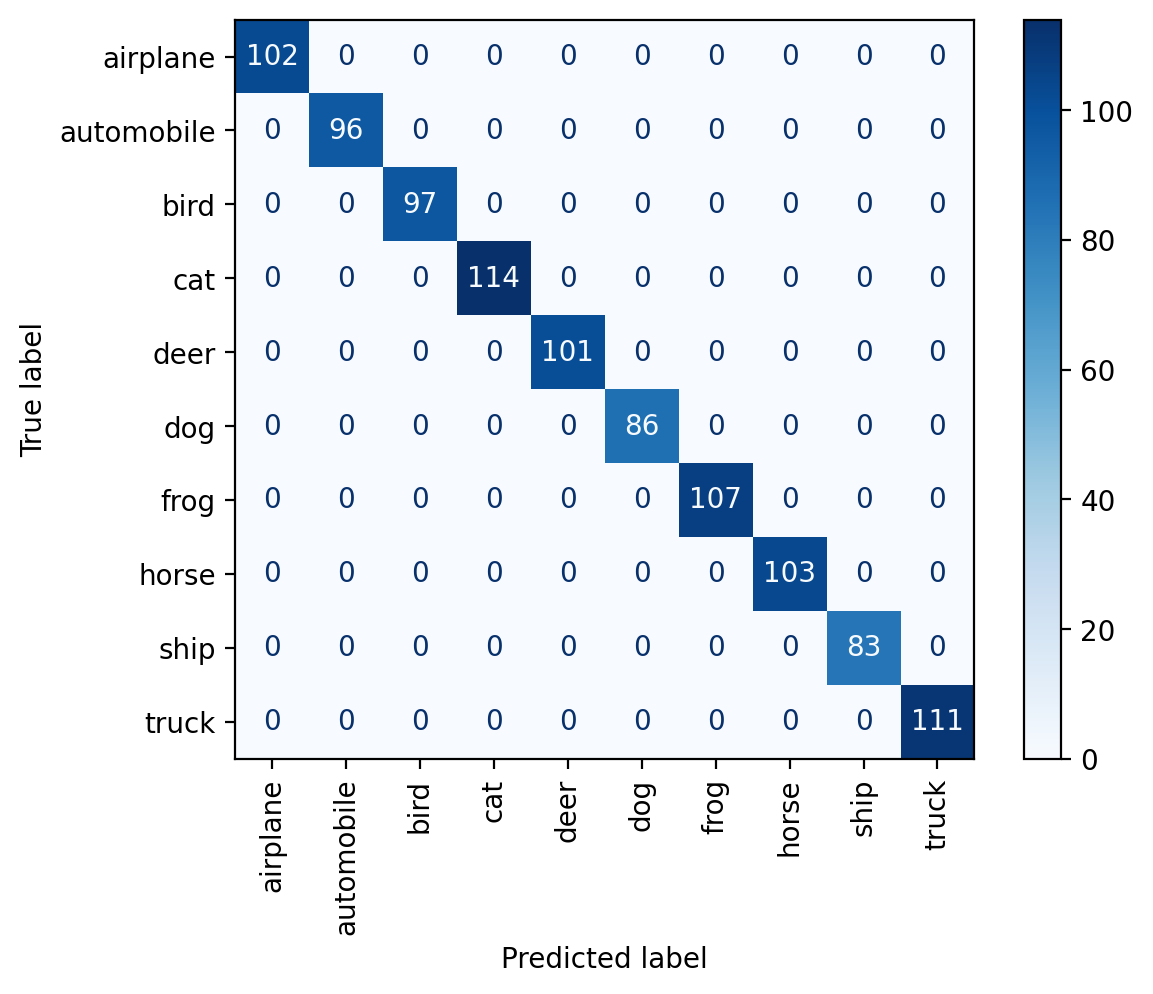

pool set accuracy: 99.99%


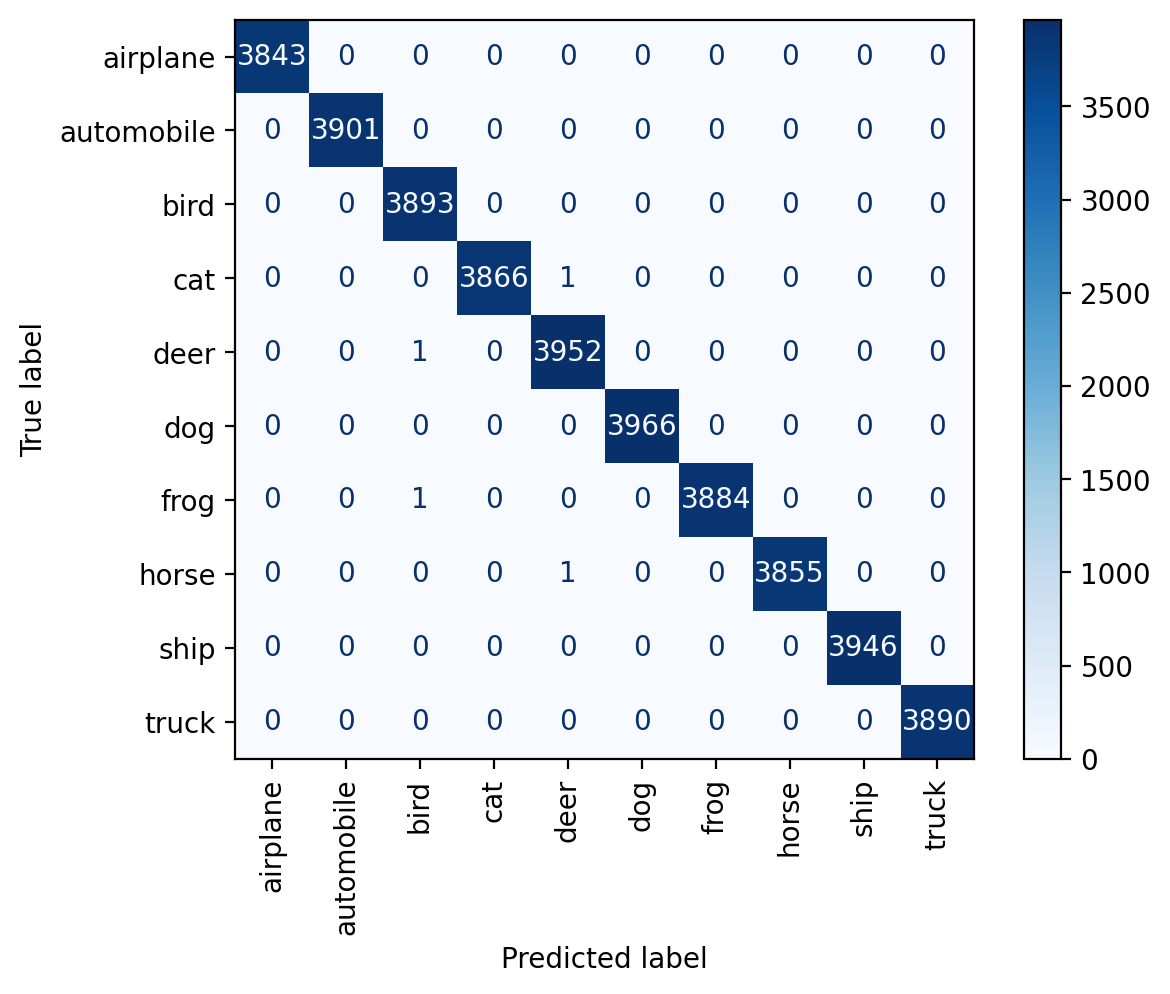

test set accuracy: 63.41%


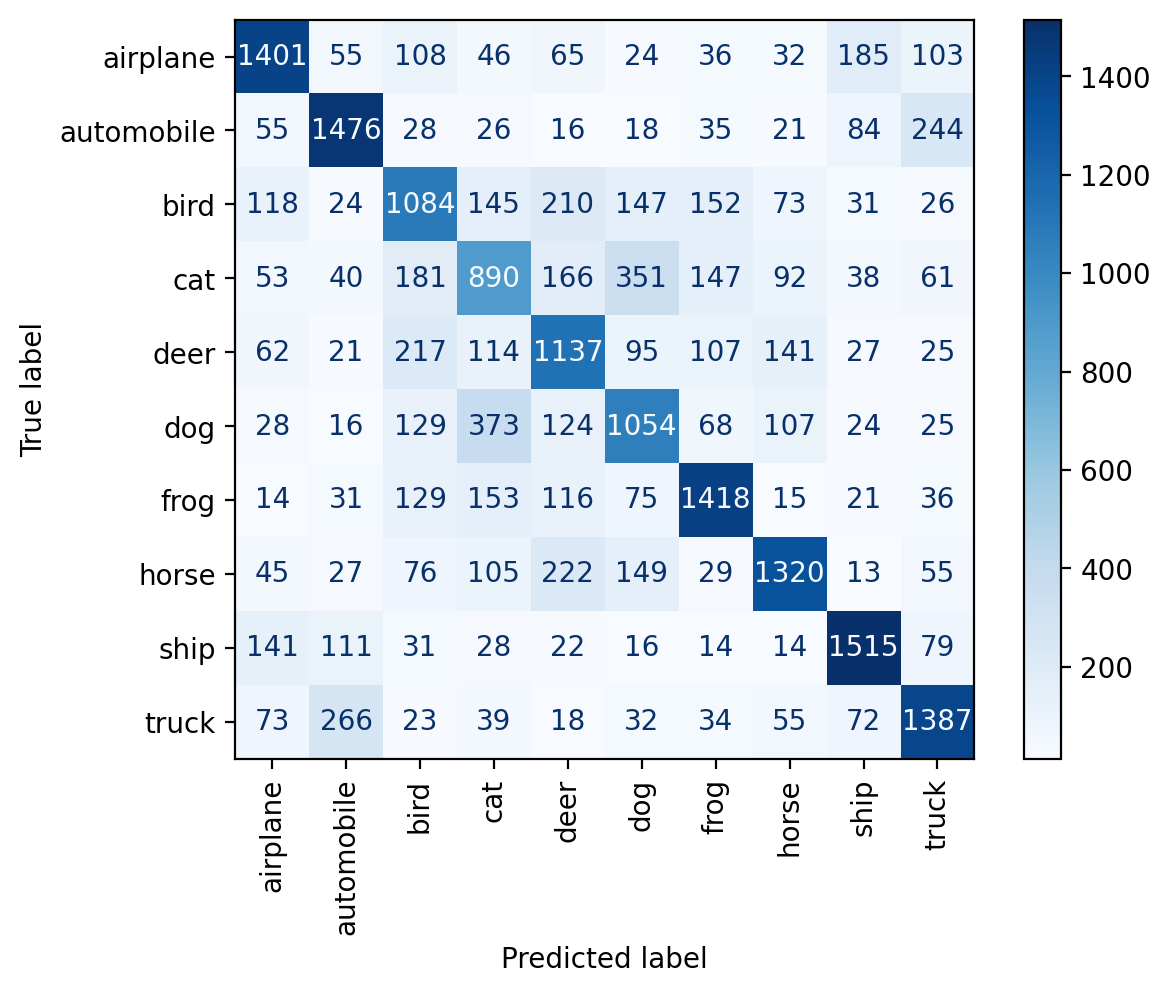

In [105]:
predict(model_train_plus_pool, dataset.classes, plot_confusion_matrix=True)

Text(0, 0.5, 'Accuracy')

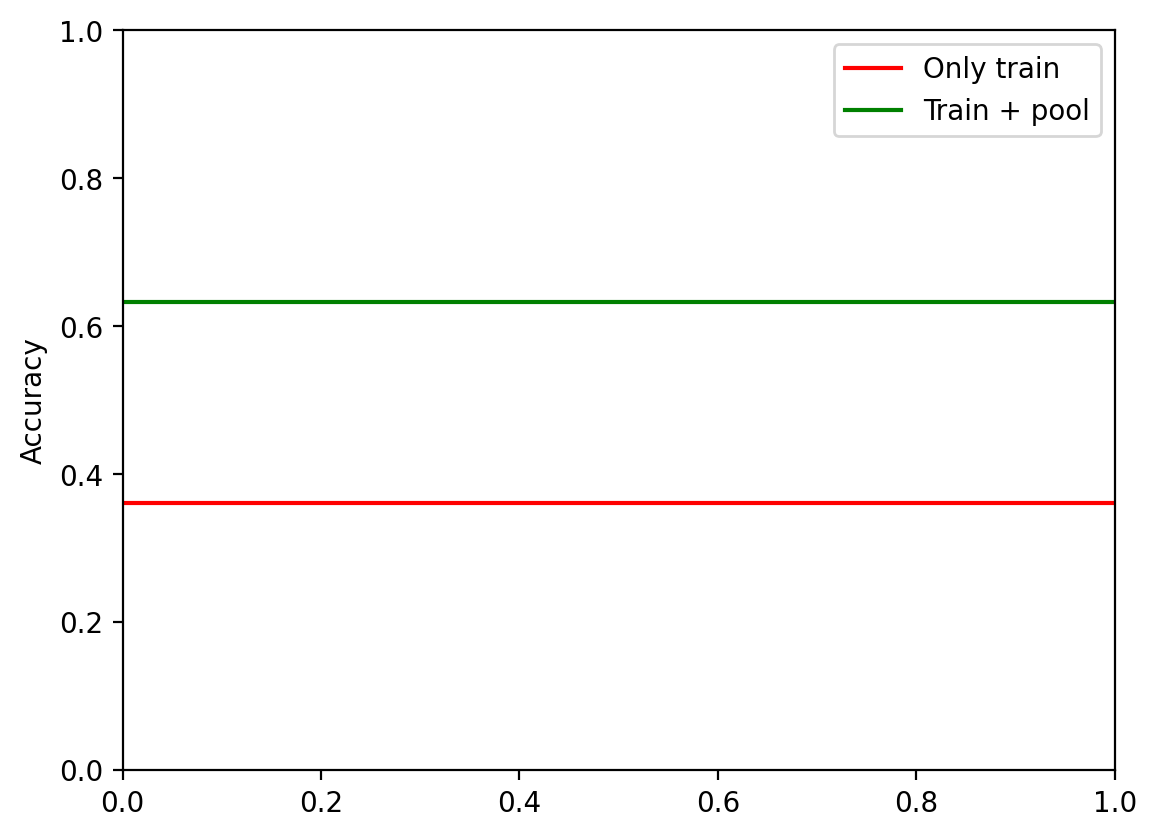

In [109]:
accuracy_only_train = get_accuracy(model_only_train, X[test_idx].to(device), y[test_idx].to(device))[1]
accuracy_train_plus_pool = get_accuracy(model_train_plus_pool, X[test_idx].to(device), y[test_idx].to(device))[1]

plt.axhline(accuracy_only_train.cpu(), color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')
plt.legend()

plt.ylabel("Accuracy")

### Active learning loop



In [26]:
def setdiff1d(a, b):
    mask = ~a.unsqueeze(1).eq(b).any(dim=1)
    return torch.masked_select(a, mask)

a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 3, 5])

print(setdiff1d(a, b))

a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 2, 3, 4, 5])

print(setdiff1d(a, b))

tensor([2, 4])
tensor([], dtype=torch.int64)


In [173]:
def al_loop(model, query_strategy, num_al_iterations, num_epochs_finetune,
            train_idx, pool_idx, test_idx, query_size, 
            X, y, device, random_seed=0, verbose=False):
    """
    model: PyTorch model trained on train_idx
    query_strategy: function that takes in model and pool_idx, 
                train_idx and returns indices to query
    num_al_iterations: number of active learning iterations
    num_epochs_finetune: number of epochs to train on queried data + train_idx
    train_idx: indices of data used for training
    pool_idx: indices of data used for querying
    test_idx: indices of data used for testing
    query_size: number of data points to query at each iteration
    X: data
    y: labels
    device: torch device
    random_seed: random seed
    verbose: print statements
    """
    tr_idx = train_idx.clone()
    p_idx = pool_idx.clone()
    torch.manual_seed(random_seed)
    
    print(f"Initial train size: {train_idx.shape}")
    print(f"Initial pool size: {pool_idx.shape}")
    
    # Initial model test accuracy
    init_accuracy = get_accuracy(model, X[test_idx].to(device), y[test_idx].to(device))[1].item()
    print(f"Test accuracy before AL: {init_accuracy:0.4f}")
    
    # Test accuracies
    test_accuracies = {0: init_accuracy}
    
    for iteration in range(num_al_iterations):
        
        # Query
        query_idx = query_strategy(model, p_idx, tr_idx, random_seed, query_size, X, y, device)
        # Add queried data to train_idx
        tr_idx = torch.cat([tr_idx, query_idx])
        # Remove queried data from pool_idx
        p_idx = setdiff1d(p_idx, query_idx)
        # Retrain model on pooled data
        iter_losses, epoch_losses = train_fn(model, X[train_idx], y[train_idx], loss_fn=nn.CrossEntropyLoss(),
                                             lr=3e-4, batch_size=1024,
                                             epochs=num_epochs_finetune, 
                                             verbose=False)
        test_accuracies[iteration+1] = get_accuracy(model, X[test_idx].to(device), y[test_idx].to(device))[1].item()
        if verbose:
            print(f"Active learning iteration {iteration+1}/{num_al_iterations}")
            print(f"Train set size: {len(tr_idx)}, Pool set size: {len(p_idx)}")
            print(f"Test accuracy: {test_accuracies[iteration]:0.4f}")
            print()
    return model, tr_idx, p_idx, test_accuracies      
    

In [174]:
def random_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    query_idx = pool_idx[torch.randperm(len(pool_idx))[:query_size]]
    return query_idx


In [175]:
query_size = 100
num_al_iterations = 100

In [177]:

import copy

model_r = copy.deepcopy(model_only_train)

model, t_idx, p_idx, test_acc_random = al_loop(model_r, random_sampling, num_al_iterations, 1, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=True)

Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3584
Active learning iteration 1/100
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3584

Active learning iteration 2/100
Train set size: 1200, Pool set size: 38800
Test accuracy: 0.3555

Active learning iteration 3/100
Train set size: 1300, Pool set size: 38700
Test accuracy: 0.3577

Active learning iteration 4/100
Train set size: 1400, Pool set size: 38600
Test accuracy: 0.3451

Active learning iteration 5/100
Train set size: 1500, Pool set size: 38500
Test accuracy: 0.3449

Active learning iteration 6/100
Train set size: 1600, Pool set size: 38400
Test accuracy: 0.3516

Active learning iteration 7/100
Train set size: 1700, Pool set size: 38300
Test accuracy: 0.3289

Active learning iteration 8/100
Train set size: 1800, Pool set size: 38200
Test accuracy: 0.3476

Active learning iteration 9/100
Train set size: 1900, Pool set size: 38100
Test accuracy: 0.3426

Active l

<AxesSubplot:>

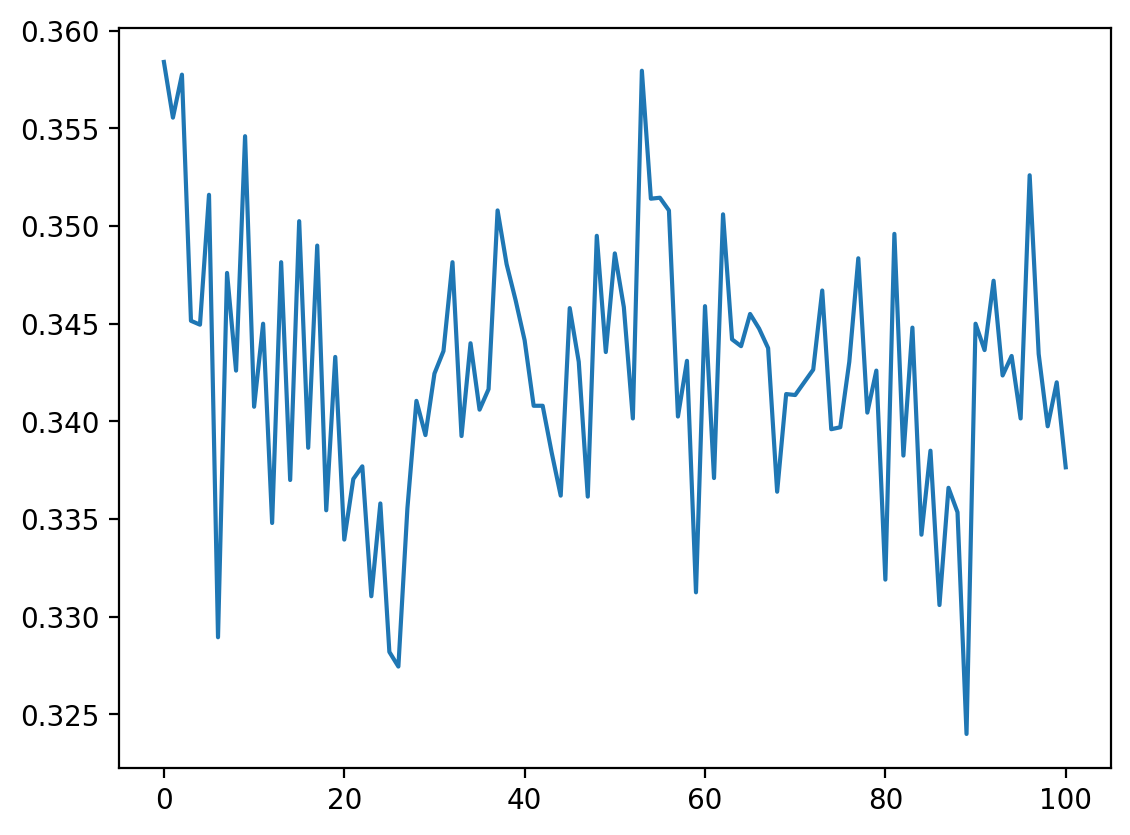

In [178]:
pd.Series(test_acc_random).plot()

In [154]:
### Now, running across multiple random seeds

query_size = 100
num_al_iterations = 30
ms = {}
t_idxs = {}
p_idxs = {}
test_acc_random = {}
for rs in range(5):
    print(f"Random seed: {rs}")
    model = copy.deepcopy(model_only_train)
    ms[rs], t_idxs[rs], p_idxs[rs], test_acc_random[rs] = al_loop(model, random_sampling, num_al_iterations, 30, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=False, random_seed=rs)


Random seed: 0


KeyboardInterrupt: 

In [116]:
test_acc_random_df = pd.DataFrame(test_acc_random)
mean_acc = test_acc_random_df.mean(axis=1)
std_acc = test_acc_random_df.std(axis=1)

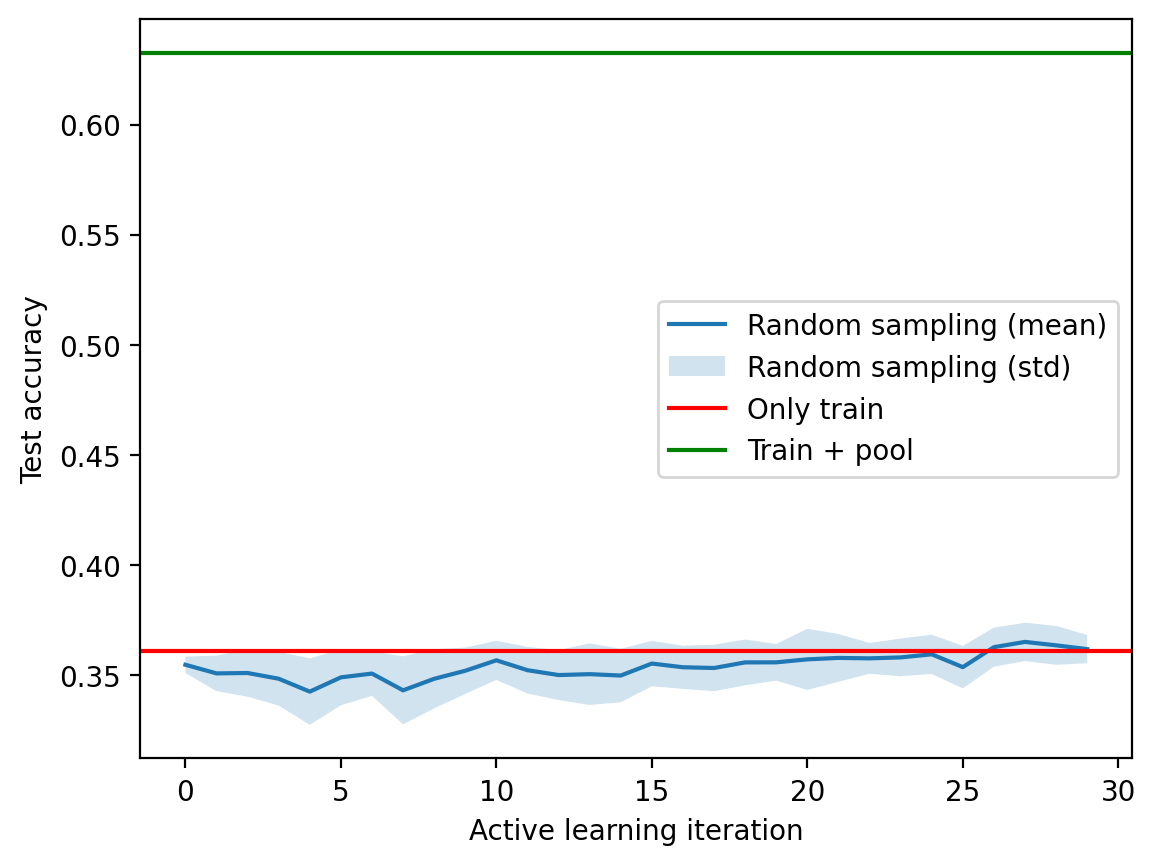

In [157]:
plt.plot(mean_acc, label="Random sampling (mean)")
plt.fill_between(mean_acc.index, mean_acc-std_acc,
                 mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")

# Accuracy of model trained on train_idx
plt.axhline(accuracy_only_train.cpu(), color='r', label='Only train')

# Accuracy of model trained on train_idx + pool_idx
plt.axhline(accuracy_train_plus_pool.cpu(), color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.legend()

In [179]:
def entropy_sampling(model, pool_idx, train_idx, random_seed, query_size, X, y, device):
    torch.manual_seed(random_seed)
    with torch.no_grad():
        logits = model(X[pool_idx].to(device))    
        probs = F.softmax(logits, dim=1)
        entropy = torch.sum(-probs * torch.log(probs), dim=1)
        entropy_sorted = entropy.sort(descending=True)
        query_idx = pool_idx.to(device)[entropy_sorted.indices[:query_size]]
    return query_idx.cpu()

In [180]:
entropy_sampling(model_only_train, pool_idx, train_idx, 0, 5, X, y, device)

tensor([50193, 42963, 30720, 24439, 58280])

In [181]:
model_e = copy.deepcopy(model_only_train)
# AL loop

m, p_idx, t_idx, test_acc_entropy  = al_loop(model_e, entropy_sampling, num_al_iterations, 1, train_idx, pool_idx, test_idx, query_size, X, y,device=device,verbose=True, random_seed=rs)


Initial train size: torch.Size([1000])
Initial pool size: torch.Size([39000])
Test accuracy before AL: 0.3584
Active learning iteration 1/100
Train set size: 1100, Pool set size: 38900
Test accuracy: 0.3584

Active learning iteration 2/100
Train set size: 1200, Pool set size: 38800
Test accuracy: 0.3576

Active learning iteration 3/100
Train set size: 1300, Pool set size: 38700
Test accuracy: 0.3490

Active learning iteration 4/100
Train set size: 1400, Pool set size: 38600
Test accuracy: 0.3492

Active learning iteration 5/100
Train set size: 1500, Pool set size: 38500
Test accuracy: 0.3454

Active learning iteration 6/100
Train set size: 1600, Pool set size: 38400
Test accuracy: 0.3402

Active learning iteration 7/100
Train set size: 1700, Pool set size: 38300
Test accuracy: 0.3291

Active learning iteration 8/100
Train set size: 1800, Pool set size: 38200
Test accuracy: 0.3447

Active learning iteration 9/100
Train set size: 1900, Pool set size: 38100
Test accuracy: 0.3389

Active l

<AxesSubplot:>

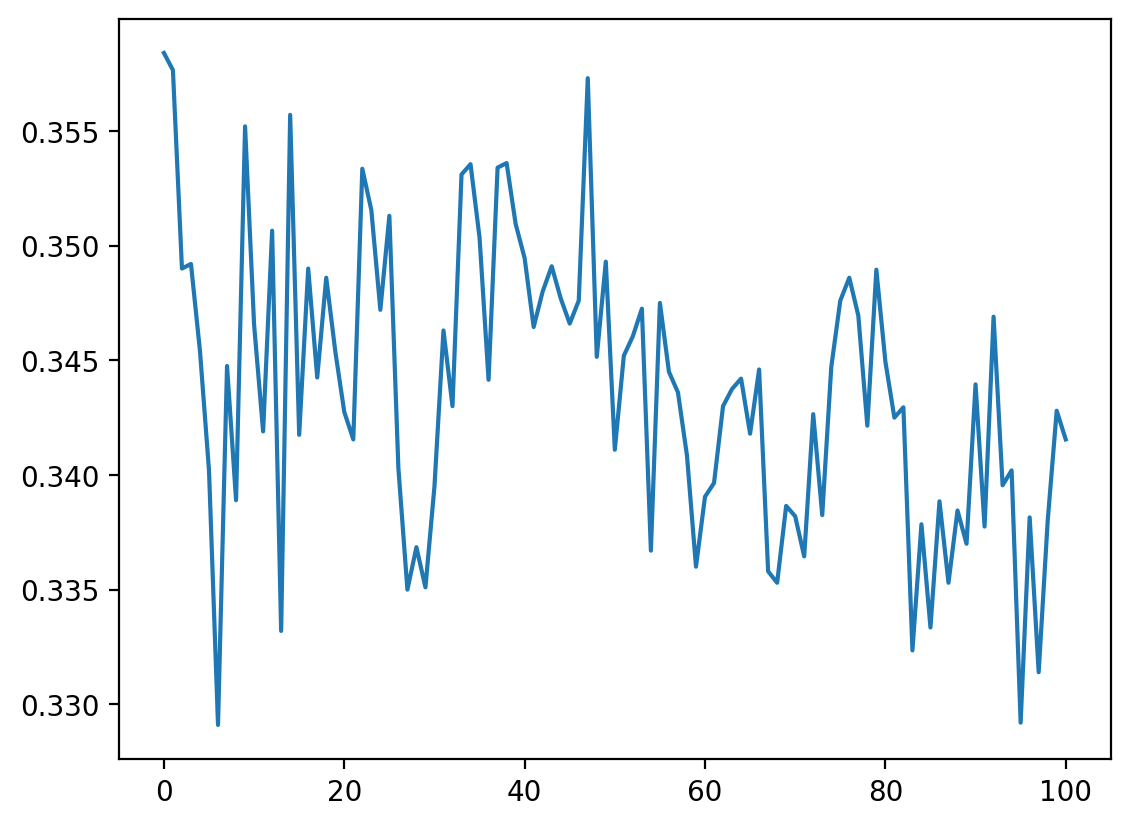

In [182]:
pd.Series(test_acc_entropy).plot()

In [ ]:
def margin_